In [1]:
import boto3
import time
import json

session = boto3.Session(profile_name='nikita')
log_client = session.client('logs')


import numpy as np
import math
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Query results

In [2]:
query = log_client.start_query(
    logGroupName='/aws/batch/job',
    startTime=0,
    endTime=int(time.time()),
    queryString="""
        fields @message
        | filter success == 1
        | limit 10000
    """,
    limit=10000
)

In [3]:
query_result = {'status': 'Scheduled'}
while query_result['status'] in ('Scheduled', 'Running'):
    query_result = log_client.get_query_results(queryId=query['queryId'])
    time.sleep(1)

In [4]:
data = [
    json.loads(row[0]['value'])
    for row in query_result['results']
]

In [5]:
data[0]

{'player': 'GreedyPlayer(0, 0.05)',
 'opponent': 'GreedyPlayer(1, 0.1)',
 'duration': 0.0049,
 'depth': 20,
 'score': [10, 25],
 'winner': 1,
 'success': True}

In [6]:
len(data)

6060

In [7]:
useful = [x for x in data if x['player'].startswith('GreedyPlayer') and x['opponent'].startswith('GreedyPlayer')]

In [8]:
from datetime import timedelta as td
class GreedyPlayer:
    def __init__(self, *args, **kwargs):
        self.args = args
        self.kwargs = kwargs

In [9]:
player_win = np.zeros(shape=(21, 21))
total_matches = np.zeros(shape=(21, 21))
space = np.linspace(0, 1, 21)

for match in useful:
    player = eval(match['player']).args[1]
    opponent = eval(match['opponent']).args[1]
    player_i = np.where(np.isclose(space, player))[0][0]
    opponent_i = np.where(np.isclose(space, opponent))[0][0]
    
    if match['winner'] == 0:
        player_win[player_i][opponent_i] += 1
        
    total_matches[player_i][opponent_i] += 1


Text(0.5, 0, 'Eps of player B')

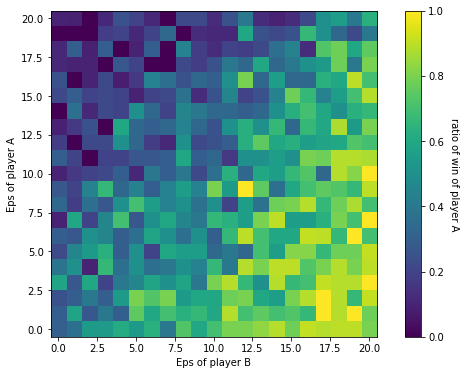

In [10]:
plt.figure(figsize=(10, 6))

plt.imshow(player_win/total_matches, origin='lower')

cb = plt.colorbar()
cb.set_label('ratio of win of player A', rotation=270)
cb.ax.get_yaxis().labelpad = 15

plt.ylabel("Eps of player A")
plt.xlabel("Eps of player B")

In [11]:
mat = player_win/total_matches

# Fold triangle

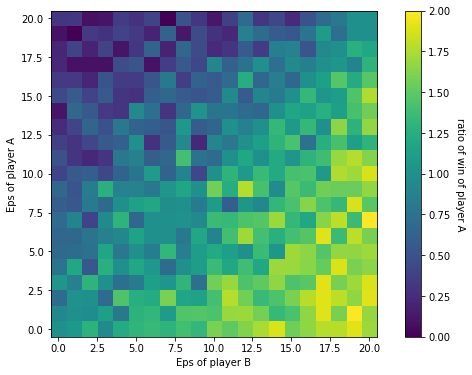

In [14]:
plt.figure(figsize=(10, 6))

plt.imshow(mat + (1 - np.transpose(mat)), origin='lower')

cb = plt.colorbar()
cb.set_label('ratio of win of player A', rotation=270)
cb.ax.get_yaxis().labelpad = 15

plt.ylabel("Eps of player A")
plt.xlabel("Eps of player B");
plt.savefig("plot-eps.png")

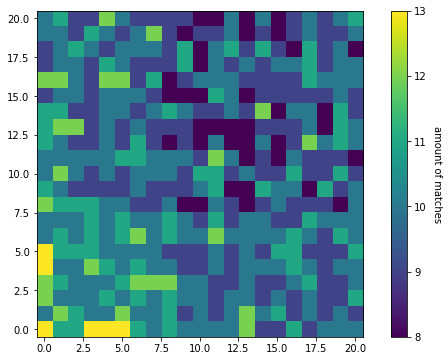

In [13]:
plt.figure(figsize=(10, 6))

plt.imshow(total_matches, origin='lower')

cb = plt.colorbar()
cb.set_label('amount of matches', rotation=270)
cb.ax.get_yaxis().labelpad = 15

# Ne montrer que un triangle de la matrice